In [24]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from src.PDE_Solver import PDESolver_nd
from src.solver_2d import false_transient_one_iteration_python
from src.derivative import derivatives_2d, derivative_1d

from src.supportfunctions import finiteDiff, PDESolver_2d
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

In [25]:
# parameters
delta        = 0.01
eta          = 0.032
xi_a         = 0.01
theta_list   = pd.read_csv("../ClimateUncertaintySpillover_ov/data/model144.csv", header=None)[0].to_numpy()
theta_list   = theta_list/1000
theta = np.mean(theta_list)
sigma_y = 1.2 * theta
# damage function
y_bar        = 2
gamma_1      = 0.00017675
gamma_2      = 2*0.0022
gamma_3_list = np.linspace(0., 1./3, 5)
gamma_3=0
# y grid
# λ = np.log(2)/6
lambda0     = np.log(2)/6

In [26]:
#Discretization of the State Space
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat)= np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace      = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])

hy1  = y1_grid[1] - y1_grid[0]
hy2  = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [27]:
#Hypyerparmaters
tol = 1e-7
epsilon = .01
#Similar Function to the One found in Suri's Notebook
def solve_prep(y1_mat, y2_mat, gamma_3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05): 
    #Define Intial Guess values
    V_new =  - eta*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
    lhs_error = 0.5
    count = 0
    E_new = eta*np.ones(y1_mat.shape)
    E_old = E_new
    E = E_new
    pi_ao = np.ones((len(theta_list), n_y1, n_y2))/len(theta_list)
    theta_mat = np.zeros((len(theta_list), n_y1, n_y2))
    for i in range(len(theta_list)):
        theta_mat[i] = theta_list[i]
    pi_a = pi_ao
    log_prob_ratio = np.zeros_like(theta_mat)
    while lhs_error > tol and count < max_iter:
        if count ==0:
            V =  - eta*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = V.copy()
        #Apply Finite Difference 
        dVdy1 = finiteDiff(V, 0,1,hy1)
        dVdy2 = finiteDiff(V, 1,1,hy2)
        #Solve for the probabilities first
        weight = np.array([-1/xi_a*dVdy2*lambda0*E*theta for theta in theta_list])
        weight = weight - np.max(weight, axis=0)
        pi_a = pi_ao*np.exp(weight)
        pi_a[pi_a<1e-15] = 1e-15
        pi_a = pi_a/np.sum(pi_a, axis=0)
        #Solve for the Emissions next
        E_new =  - eta/(dVdy2*lambda0*np.sum(theta_mat*pi_a, axis=0))
        E_new[E_new <= 1e-15] = 1e-15
        E = E_new*fraction + E_old*(1 - fraction)
        #Use Above to compute the Coeffecients
        #Computation of the Coeffecients 
        A = np.ones_like(y1_mat)*(-delta)
        B_y1 = y2_mat
        B_y2 = (-y2_mat + np.sum(theta_mat*pi_a,axis=0)*E)*lambda0
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = (eta-1)/delta \
                * (gamma_1+gamma_2*y1_mat + gamma_3*(y1_mat-y_bar)*(y1_mat>y_bar))*y2_mat\
                +np.log(E)*eta \
                + xi_a*np.sum(pi_a*(np.log(pi_a)-np.log(pi_ao)), axis=0)
        #Use Coefficients as inputs of the PDESolver
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, V, epsilon, solverType = 'False Transient')
        #Outputs and Errors of the code
        out_comp = out[2].reshape(V.shape,order = "F")
        rhs = A*V + B_y1*dVdy1 + B_y2*dVdy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - V)/epsilon))
        count = count+ 1
        V = out_comp
        E_old = E
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(count, rhs_error, lhs_error, out[0], out[1]))
    result = dict(E=E, V=V_new, pi_a=pi_a)
    return result 

In [31]:
res_list = {}
i=0
for gamma_3_i in gamma_3_list:
    safe = solve_prep(y1_mat, y2_mat, gamma_3_i, 1e-6, 0.001, 2000, 0.05)
    res_list[i]  = safe
    i=i+1

Episode 2000: PDE Error: 0.060716252229; False Transient Error: 0.060699897672; Iterations: 6; CG Error: 0.000000000009
Episode 2000: PDE Error: 0.111767292276; False Transient Error: 0.111664328785; Iterations: 5; CG Error: 0.000000000075
Episode 2000: PDE Error: 0.204257462825; False Transient Error: 0.204059623131; Iterations: 5; CG Error: 0.000000000052
Episode 2000: PDE Error: 0.290154124704; False Transient Error: 0.289862120383; Iterations: 5; CG Error: 0.000000000042
Episode 2000: PDE Error: 0.373211538108; False Transient Error: 0.372825662955; Iterations: 5; CG Error: 0.000000000036


NameError: name 'γ3_list' is not defined

In [38]:
ϕ_list = np.zeros((len(gamma_3_list), len(y1_grid), len(y2_grid)))
ems_list = np.zeros((len(gamma_3_list), len(y1_grid), len(y2_grid)))
for j in range(len(gamma_3_list)):
    ϕ_list[j] = res_list[j]['V']
    ems_list[j] = res_list[j]['E']

np.save("v_list_2", ϕ_list)
np.save("e_list_2", ems_list)

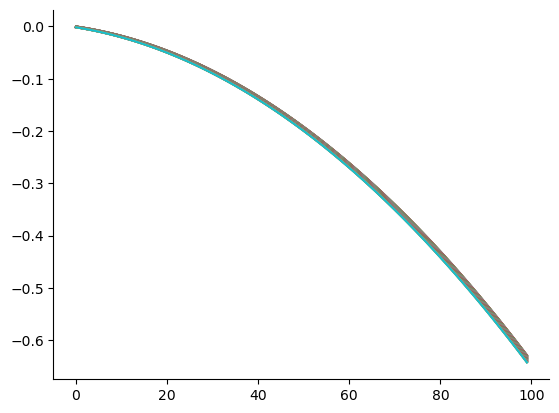

In [39]:
loc_start = np.abs(y2_grid - np.mean(theta_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(theta_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(theta_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

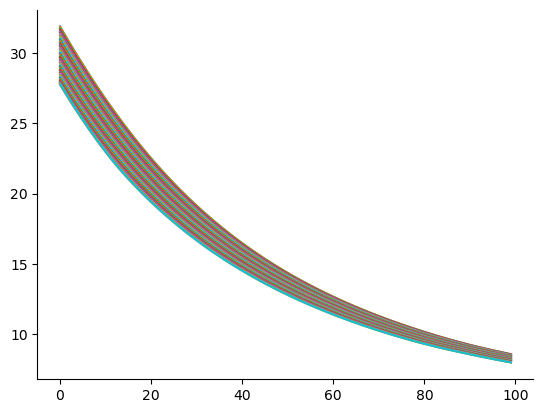

In [40]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()


In [41]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
xi_p = 1
epsilon = 0.1
max_iter = 2000
dmg_weight = np.ones(len(gamma_3_list)) / len(gamma_3_list)
ϕ_list = np.zeros((len(gamma_3_list), len(y1_grid), len(y2_grid)))
ϕ_weight = np.average(np.exp(-1 / xi_p * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -xi_p * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
pi_do = np.ones((len(gamma_3_list), num_y1, num_y2)) / len(gamma_3_list)
pi_ao = np.ones((len(theta_list), num_y1, num_y2)) / len(theta_list)
theta_mat = np.zeros((len(theta_list), num_y1, num_y2))
for i in range(len(theta_list)):
    theta_mat[i] = theta_list[i]
DF1 = gamma_1 + gamma_2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)



In [42]:
# initiate v and control
tol = 1e-6
E = eta
E_old = E
lhs_error = 1
count = 0
fraction=0.05
V = ϕ_equiv[:num_y1]
V_m = np.zeros(pi_do.shape)
log_prob_ratio = np.zeros_like(theta_mat)
for i in range(len(gamma_3_list)):
    V_m[i] = ϕ_list[i][loc_2]

In [43]:
while lhs_error > tol and count < max_iter:
    V0_old = V.copy()
    dVdy1 = derivatives_2d(V, 0,1,hy1)
    dVdy2 = derivatives_2d(V, 1,1,hy2)
    #computation of controls using backwards and forward difference
    weight = np.array([-1/xi_a * dVdy2 * lambda0 * E_old * theta for theta in theta_list])
    weight = weight - np.max(weight, axis=0)
    pi_a = pi_ao*np.exp(weight)
    pi_a[pi_a<1e-15] = 1e-15
    pi_a = pi_a/np.sum(pi_a, axis=0) 
    E_new =  - eta/(dVdy2*lambda0*np.sum(theta_mat*pi_a, axis=0))
    E_new[E_new <= 1e-15] = 1e-15
    E = E_new*fraction + E_old*(1 - fraction)
    E[E <= 1e-10] = 1e-10
    # updating controls
    #     print(np.min(ems))
    g_m = np.exp(1 / xi_p * (V - V_m))
    # HJB coefficient
    A = np.ones_like(y1_mat_cap)*(-delta)- Intensity * np.sum(pi_do * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = (-y2_mat_cap + np.sum(theta_mat*pi_a,axis=0)*E)*lambda0
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = (eta-1)/delta \
      * DF1*y2_mat_cap\
      +np.log(E)*eta \
      + xi_a*np.sum(pi_a*(np.log(pi_a)-np.log(pi_ao)), axis=0)\
      + Intensity * np.sum(pi_do * g_m * V_m, axis=0)\
      + xi_p * Intensity * np.sum(pi_do*(1-g_m+g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        V,
        epsilon,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * dVdy1 + B_y2 * dVdy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - V) / epsilon))
    V = phi_mat
    E_old = E
    count += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(count, lhs_error, rhs_error))

<ipython-input-43-eabe1df1db24>:11: RuntimeWarning: divide by zero encountered in true_divide
  E_new =  - eta/(dVdy2*lambda0*np.sum(theta_mat*pi_a, axis=0))


Episode: 1	 lhs error: 0.146999361850	 rhs error: 0.147450398404
Episode: 2	 lhs error: 0.253815497479	 rhs error: 0.266654175584
Episode: 3	 lhs error: 0.243146424856	 rhs error: 0.253871451871
Episode: 4	 lhs error: 0.233474822594	 rhs error: 0.242646555099
Episode: 5	 lhs error: 0.225020608666	 rhs error: 0.233115251348
Episode: 6	 lhs error: 0.217444088754	 rhs error: 0.224924223322
Episode: 7	 lhs error: 0.210408218773	 rhs error: 0.217818196364
Episode: 8	 lhs error: 0.203655477284	 rhs error: 0.211021643210
Episode: 9	 lhs error: 0.197036555694	 rhs error: 0.204339597509
Episode: 10	 lhs error: 0.190530644400	 rhs error: 0.198387283485
Episode: 11	 lhs error: 0.184065671498	 rhs error: 0.191678366444
Episode: 12	 lhs error: 0.177733315120	 rhs error: 0.185809073143
Episode: 13	 lhs error: 0.171528400902	 rhs error: 0.179852994639
Episode: 14	 lhs error: 0.165501543977	 rhs error: 0.173756986360
Episode: 15	 lhs error: 0.159695790419	 rhs error: 0.167697868717
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.088299756014	 rhs error: 0.088894244409
Episode: 126	 lhs error: 0.087917148972	 rhs error: 0.088526728704
Episode: 127	 lhs error: 0.087609027519	 rhs error: 0.088175842061
Episode: 128	 lhs error: 0.087264439932	 rhs error: 0.087809997681
Episode: 129	 lhs error: 0.086870876350	 rhs error: 0.087442612994
Episode: 130	 lhs error: 0.086560237865	 rhs error: 0.087111629280
Episode: 131	 lhs error: 0.086203782833	 rhs error: 0.086723372853
Episode: 132	 lhs error: 0.085843948452	 rhs error: 0.086382523493
Episode: 133	 lhs error: 0.085493583290	 rhs error: 0.086039127991
Episode: 134	 lhs error: 0.085157204911	 rhs error: 0.085689110021
Episode: 135	 lhs error: 0.084839275092	 rhs error: 0.085332214883
Episode: 136	 lhs error: 0.084469317316	 rhs error: 0.084961906547
Episode: 137	 lhs error: 0.084165848462	 rhs error: 0.084630729156
Episode: 138	 lhs error: 0.083779457417	 rhs error: 0.084272060869
Episode: 139	 lhs error: 0.083423162990	 rhs error: 0.08394243

Episode: 249	 lhs error: 0.057656873347	 rhs error: 0.057817762945
Episode: 250	 lhs error: 0.057501455382	 rhs error: 0.057661152991
Episode: 251	 lhs error: 0.057346846453	 rhs error: 0.057505366542
Episode: 252	 lhs error: 0.057193035901	 rhs error: 0.057350392571
Episode: 253	 lhs error: 0.057040013316	 rhs error: 0.057196220314
Episode: 254	 lhs error: 0.056887768637	 rhs error: 0.057042839270
Episode: 255	 lhs error: 0.056736292031	 rhs error: 0.056890239204
Episode: 256	 lhs error: 0.056585573861	 rhs error: 0.056738410136
Episode: 257	 lhs error: 0.056435604856	 rhs error: 0.056587562516
Episode: 258	 lhs error: 0.056286375889	 rhs error: 0.056437658239
Episode: 259	 lhs error: 0.056137878067	 rhs error: 0.056288495675
Episode: 260	 lhs error: 0.055990102693	 rhs error: 0.056140065778
Episode: 261	 lhs error: 0.055843041323	 rhs error: 0.055992359732
Episode: 262	 lhs error: 0.055696685659	 rhs error: 0.055845368959
Episode: 263	 lhs error: 0.055551027796	 rhs error: 0.05569908

Episode: 373	 lhs error: 0.042678904917	 rhs error: 0.042765904973
Episode: 374	 lhs error: 0.042567579346	 rhs error: 0.042670749122
Episode: 375	 lhs error: 0.042426015885	 rhs error: 0.042574085907
Episode: 376	 lhs error: 0.042313375258	 rhs error: 0.042474303584
Episode: 377	 lhs error: 0.042247815398	 rhs error: 0.042376688351
Episode: 378	 lhs error: 0.042165716573	 rhs error: 0.042279226878
Episode: 379	 lhs error: 0.042084378499	 rhs error: 0.042182669108
Episode: 380	 lhs error: 0.041996446765	 rhs error: 0.042085714551
Episode: 381	 lhs error: 0.041895502378	 rhs error: 0.041990070523
Episode: 382	 lhs error: 0.041792936652	 rhs error: 0.041894621334
Episode: 383	 lhs error: 0.041741393191	 rhs error: 0.041799233825
Episode: 384	 lhs error: 0.041593990080	 rhs error: 0.041704688361
Episode: 385	 lhs error: 0.041499610815	 rhs error: 0.041611925679
Episode: 386	 lhs error: 0.041427273643	 rhs error: 0.041516160386
Episode: 387	 lhs error: 0.041319793060	 rhs error: 0.04142188

Episode: 496	 lhs error: 0.032003102150	 rhs error: 0.032083250063
Episode: 497	 lhs error: 0.031932135061	 rhs error: 0.032007348960
Episode: 498	 lhs error: 0.031779059887	 rhs error: 0.031932162346
Episode: 499	 lhs error: 0.031747693994	 rhs error: 0.031852831163
Episode: 500	 lhs error: 0.031712851789	 rhs error: 0.031775954413
Episode: 501	 lhs error: 0.031581334066	 rhs error: 0.031700282454
Episode: 502	 lhs error: 0.031544334808	 rhs error: 0.031620195551
Episode: 503	 lhs error: 0.031464723885	 rhs error: 0.031543684078
Episode: 504	 lhs error: 0.031383352203	 rhs error: 0.031466864322
Episode: 505	 lhs error: 0.031312324375	 rhs error: 0.031389984572
Episode: 506	 lhs error: 0.031141786897	 rhs error: 0.031313580941
Episode: 507	 lhs error: 0.031172707853	 rhs error: 0.031234467197
Episode: 508	 lhs error: 0.031049284723	 rhs error: 0.031158459789
Episode: 509	 lhs error: 0.031003208538	 rhs error: 0.031081547061
Episode: 510	 lhs error: 0.030929338885	 rhs error: 0.03100663

Episode: 620	 lhs error: 0.023346834452	 rhs error: 0.023475518752
Episode: 621	 lhs error: 0.023346799261	 rhs error: 0.023413917531
Episode: 622	 lhs error: 0.023263621577	 rhs error: 0.023353149032
Episode: 623	 lhs error: 0.023132530823	 rhs error: 0.023292066292
Episode: 624	 lhs error: 0.023138658768	 rhs error: 0.023229969403
Episode: 625	 lhs error: 0.023028490595	 rhs error: 0.023169671194
Episode: 626	 lhs error: 0.023018972489	 rhs error: 0.023108447992
Episode: 627	 lhs error: 0.022970805650	 rhs error: 0.023048526605
Episode: 628	 lhs error: 0.022916055720	 rhs error: 0.022988888496
Episode: 629	 lhs error: 0.022859436431	 rhs error: 0.022929301514
Episode: 630	 lhs error: 0.022800495331	 rhs error: 0.022869722133
Episode: 631	 lhs error: 0.022644893314	 rhs error: 0.022810228514
Episode: 632	 lhs error: 0.022585252499	 rhs error: 0.022749869578
Episode: 633	 lhs error: 0.022612906989	 rhs error: 0.022689922012
Episode: 634	 lhs error: 0.022550634469	 rhs error: 0.02263099

Episode: 744	 lhs error: 0.016731050962	 rhs error: 0.016807869046
Episode: 745	 lhs error: 0.016683818919	 rhs error: 0.016761376764
Episode: 746	 lhs error: 0.016637421672	 rhs error: 0.016714868369
Episode: 747	 lhs error: 0.016591476567	 rhs error: 0.016668390218
Episode: 748	 lhs error: 0.016544523468	 rhs error: 0.016621965637
Episode: 749	 lhs error: 0.016497647306	 rhs error: 0.016575592820
Episode: 750	 lhs error: 0.016451880110	 rhs error: 0.016529290198
Episode: 751	 lhs error: 0.016406459275	 rhs error: 0.016483080206
Episode: 752	 lhs error: 0.016360571327	 rhs error: 0.016436964023
Episode: 753	 lhs error: 0.016201827869	 rhs error: 0.016391049807
Episode: 754	 lhs error: 0.016272450505	 rhs error: 0.016343764011
Episode: 755	 lhs error: 0.016222916924	 rhs error: 0.016298442030
Episode: 756	 lhs error: 0.016177220677	 rhs error: 0.016253001038
Episode: 757	 lhs error: 0.016131680181	 rhs error: 0.016207569039
Episode: 758	 lhs error: 0.016086205039	 rhs error: 0.01616217

Episode: 868	 lhs error: 0.011651124834	 rhs error: 0.011729391787
Episode: 869	 lhs error: 0.011613956509	 rhs error: 0.011693934024
Episode: 870	 lhs error: 0.011581778454	 rhs error: 0.011658507400
Episode: 871	 lhs error: 0.011548802139	 rhs error: 0.011623161850
Episode: 872	 lhs error: 0.011508080679	 rhs error: 0.011587885253
Episode: 873	 lhs error: 0.011464049363	 rhs error: 0.011552622991
Episode: 874	 lhs error: 0.011429151645	 rhs error: 0.011517380417
Episode: 875	 lhs error: 0.011402094724	 rhs error: 0.011482249917
Episode: 876	 lhs error: 0.011374991200	 rhs error: 0.011447268958
Episode: 877	 lhs error: 0.011310544144	 rhs error: 0.011412435068
Episode: 878	 lhs error: 0.011315885775	 rhs error: 0.011376607291
Episode: 879	 lhs error: 0.011208231681	 rhs error: 0.011342184826
Episode: 880	 lhs error: 0.011194732916	 rhs error: 0.011307229871
Episode: 881	 lhs error: 0.011161562152	 rhs error: 0.011272630570
Episode: 882	 lhs error: 0.011129115110	 rhs error: 0.01123813

Episode: 991	 lhs error: 0.007824710395	 rhs error: 0.007919432471
Episode: 992	 lhs error: 0.007799661070	 rhs error: 0.007892939728
Episode: 993	 lhs error: 0.007773988467	 rhs error: 0.007866495053
Episode: 994	 lhs error: 0.007747566189	 rhs error: 0.007840081572
Episode: 995	 lhs error: 0.007720808175	 rhs error: 0.007813699774
Episode: 996	 lhs error: 0.007694015094	 rhs error: 0.007787354873
Episode: 997	 lhs error: 0.007558485458	 rhs error: 0.007761164328
Episode: 998	 lhs error: 0.007659785412	 rhs error: 0.007734259939
Episode: 999	 lhs error: 0.007591566748	 rhs error: 0.007708782979
Episode: 1000	 lhs error: 0.007558953083	 rhs error: 0.007682685388
Episode: 1001	 lhs error: 0.007538193515	 rhs error: 0.007656510871
Episode: 1002	 lhs error: 0.007519764521	 rhs error: 0.007630424711
Episode: 1003	 lhs error: 0.007497372977	 rhs error: 0.007604500508
Episode: 1004	 lhs error: 0.007470303959	 rhs error: 0.007578662395
Episode: 1005	 lhs error: 0.007443059625	 rhs error: 0.00

Episode: 1112	 lhs error: 0.005036793531	 rhs error: 0.006397372533
Episode: 1113	 lhs error: 0.004901607813	 rhs error: 0.006403066770
Episode: 1114	 lhs error: 0.004996130905	 rhs error: 0.006400807636
Episode: 1115	 lhs error: 0.004978609402	 rhs error: 0.006402166674
Episode: 1116	 lhs error: 0.004850668969	 rhs error: 0.006407646642
Episode: 1117	 lhs error: 0.004881059626	 rhs error: 0.006408296811
Episode: 1118	 lhs error: 0.004917159329	 rhs error: 0.006408389124
Episode: 1119	 lhs error: 0.004899829433	 rhs error: 0.006409921932
Episode: 1120	 lhs error: 0.004881310050	 rhs error: 0.006411441247
Episode: 1121	 lhs error: 0.004862274460	 rhs error: 0.006412925276
Episode: 1122	 lhs error: 0.004842869606	 rhs error: 0.006414368756
Episode: 1123	 lhs error: 0.004824136111	 rhs error: 0.006415734118
Episode: 1124	 lhs error: 0.004805882994	 rhs error: 0.006417024538
Episode: 1125	 lhs error: 0.004787290734	 rhs error: 0.006418264840
Episode: 1126	 lhs error: 0.004768275071	 rhs er

Episode: 1233	 lhs error: 0.003023356792	 rhs error: 0.006484805839
Episode: 1234	 lhs error: 0.003009803517	 rhs error: 0.006484552572
Episode: 1235	 lhs error: 0.002996073193	 rhs error: 0.006484248621
Episode: 1236	 lhs error: 0.002982135203	 rhs error: 0.006483895387
Episode: 1237	 lhs error: 0.002855628756	 rhs error: 0.006487687148
Episode: 1238	 lhs error: 0.002956020515	 rhs error: 0.006483786643
Episode: 1239	 lhs error: 0.002941814577	 rhs error: 0.006483499506
Episode: 1240	 lhs error: 0.002816199752	 rhs error: 0.006487269748
Episode: 1241	 lhs error: 0.002861378876	 rhs error: 0.006485850774
Episode: 1242	 lhs error: 0.002899104843	 rhs error: 0.006484330286
Episode: 1243	 lhs error: 0.002885804857	 rhs error: 0.006484140408
Episode: 1244	 lhs error: 0.002872485446	 rhs error: 0.006483903185
Episode: 1245	 lhs error: 0.002858865204	 rhs error: 0.006483627608
Episode: 1246	 lhs error: 0.002845580510	 rhs error: 0.006483292683
Episode: 1247	 lhs error: 0.002832616038	 rhs er

Episode: 1355	 lhs error: 0.001521267557	 rhs error: 0.006498147399
Episode: 1356	 lhs error: 0.001570899339	 rhs error: 0.006497013173
Episode: 1357	 lhs error: 0.001632017395	 rhs error: 0.006495102315
Episode: 1358	 lhs error: 0.001616185597	 rhs error: 0.006495378800
Episode: 1359	 lhs error: 0.001605168234	 rhs error: 0.006495428421
Episode: 1360	 lhs error: 0.001595419392	 rhs error: 0.006495374440
Episode: 1361	 lhs error: 0.001484415709	 rhs error: 0.006498969695
Episode: 1362	 lhs error: 0.001593570935	 rhs error: 0.006495160449
Episode: 1363	 lhs error: 0.001571693860	 rhs error: 0.006495506161
Episode: 1364	 lhs error: 0.001444178881	 rhs error: 0.006499644522
Episode: 1365	 lhs error: 0.001472701795	 rhs error: 0.006499227070
Episode: 1366	 lhs error: 0.001550887564	 rhs error: 0.006496791815
Episode: 1367	 lhs error: 0.001536142015	 rhs error: 0.006497026207
Episode: 1368	 lhs error: 0.001525670679	 rhs error: 0.006497055128
Episode: 1369	 lhs error: 0.001516305361	 rhs er

Episode: 1476	 lhs error: 0.000779146260	 rhs error: 0.006482180675
Episode: 1477	 lhs error: 0.000773331917	 rhs error: 0.006482162556
Episode: 1478	 lhs error: 0.000767388391	 rhs error: 0.006482120443
Episode: 1479	 lhs error: 0.000649124538	 rhs error: 0.006486120609
Episode: 1480	 lhs error: 0.000764610617	 rhs error: 0.006482352289
Episode: 1481	 lhs error: 0.000751096463	 rhs error: 0.006482680962
Episode: 1482	 lhs error: 0.000744357965	 rhs error: 0.006482760960
Episode: 1483	 lhs error: 0.000738595415	 rhs error: 0.006482786430
Episode: 1484	 lhs error: 0.000734667602	 rhs error: 0.006482721340
Episode: 1485	 lhs error: 0.000736249545	 rhs error: 0.006482421493
Episode: 1486	 lhs error: 0.000631381155	 rhs error: 0.006485862210
Episode: 1487	 lhs error: 0.000714836130	 rhs error: 0.006483563543
Episode: 1488	 lhs error: 0.000691687610	 rhs error: 0.006484447121
Episode: 1489	 lhs error: 0.000720919450	 rhs error: 0.006483271327
Episode: 1490	 lhs error: 0.000719096530	 rhs er

Episode: 1598	 lhs error: 0.000560938932	 rhs error: 0.006477377927
Episode: 1599	 lhs error: 0.000335360277	 rhs error: 0.006473040003
Episode: 1600	 lhs error: 0.000320750042	 rhs error: 0.006473199887
Episode: 1601	 lhs error: 0.000316413716	 rhs error: 0.006472968359
Episode: 1602	 lhs error: 0.000591228683	 rhs error: 0.006477144678
Episode: 1603	 lhs error: 0.000277008468	 rhs error: 0.006474679257
Episode: 1604	 lhs error: 0.000318654281	 rhs error: 0.006473345362
Episode: 1605	 lhs error: 0.000307012400	 rhs error: 0.006473487853
Episode: 1606	 lhs error: 0.000302665467	 rhs error: 0.006473346244
Episode: 1607	 lhs error: 0.000299644250	 rhs error: 0.006473120508
Episode: 1608	 lhs error: 0.000611526147	 rhs error: 0.006477284972
Episode: 1609	 lhs error: 0.000309657267	 rhs error: 0.006472796693
Episode: 1610	 lhs error: 0.000296484910	 rhs error: 0.006472994277
Episode: 1611	 lhs error: 0.000292340869	 rhs error: 0.006472839688
Episode: 1612	 lhs error: 0.000289386510	 rhs er

Episode: 1720	 lhs error: 0.000126232334	 rhs error: 0.006468353616
Episode: 1721	 lhs error: 0.000518696311	 rhs error: 0.006471998258
Episode: 1722	 lhs error: 0.000092584870	 rhs error: 0.006469568235
Episode: 1723	 lhs error: 0.000209396273	 rhs error: 0.006468406954
Episode: 1724	 lhs error: 0.000138918723	 rhs error: 0.006468546652
Episode: 1725	 lhs error: 0.000123492780	 rhs error: 0.006468354987
Episode: 1726	 lhs error: 0.000585715988	 rhs error: 0.006472319322
Episode: 1727	 lhs error: 0.000226290635	 rhs error: 0.006467948286
Episode: 1728	 lhs error: 0.000148371921	 rhs error: 0.006468148854
Episode: 1729	 lhs error: 0.000133755294	 rhs error: 0.006467963597
Episode: 1730	 lhs error: 0.000587033463	 rhs error: 0.006472119328
Episode: 1731	 lhs error: 0.000074837142	 rhs error: 0.006469739203
Episode: 1732	 lhs error: 0.000200422093	 rhs error: 0.006468461590
Episode: 1733	 lhs error: 0.000140630775	 rhs error: 0.006468636088
Episode: 1734	 lhs error: 0.000126899688	 rhs er

Episode: 1841	 lhs error: 0.000126005361	 rhs error: 0.006469277726
Episode: 1842	 lhs error: 0.000119964781	 rhs error: 0.006469083730
Episode: 1843	 lhs error: 0.000585297123	 rhs error: 0.006473074023
Episode: 1844	 lhs error: 0.000222800015	 rhs error: 0.006468766798
Episode: 1845	 lhs error: 0.000149249697	 rhs error: 0.006468988590
Episode: 1846	 lhs error: 0.000135380019	 rhs error: 0.006468842186
Episode: 1847	 lhs error: 0.000129128854	 rhs error: 0.006468612611
Episode: 1848	 lhs error: 0.000575767876	 rhs error: 0.006472666168
Episode: 1849	 lhs error: 0.000047841506	 rhs error: 0.006470186420
Episode: 1850	 lhs error: 0.000203287784	 rhs error: 0.006468985791
Episode: 1851	 lhs error: 0.000140345193	 rhs error: 0.006469151731
Episode: 1852	 lhs error: 0.000125904507	 rhs error: 0.006469016127
Episode: 1853	 lhs error: 0.000120107186	 rhs error: 0.006468794954
Episode: 1854	 lhs error: 0.000577734433	 rhs error: 0.006472712929
Episode: 1855	 lhs error: 0.000225519304	 rhs er

Episode: 1963	 lhs error: 0.000148633833	 rhs error: 0.006469383281
Episode: 1964	 lhs error: 0.000133936954	 rhs error: 0.006469226848
Episode: 1965	 lhs error: 0.000588454942	 rhs error: 0.006473418221
Episode: 1966	 lhs error: 0.000048172911	 rhs error: 0.006471005568
Episode: 1967	 lhs error: 0.000200402354	 rhs error: 0.006469789368
Episode: 1968	 lhs error: 0.000140695814	 rhs error: 0.006469981162
Episode: 1969	 lhs error: 0.000126971292	 rhs error: 0.006469884749
Episode: 1970	 lhs error: 0.000121221845	 rhs error: 0.006469703404
Episode: 1971	 lhs error: 0.000118827981	 rhs error: 0.006469463507
Episode: 1972	 lhs error: 0.000533901573	 rhs error: 0.006473105550
Episode: 1973	 lhs error: 0.000231911510	 rhs error: 0.006468963569
Episode: 1974	 lhs error: 0.000147193864	 rhs error: 0.006469195152
Episode: 1975	 lhs error: 0.000609013803	 rhs error: 0.006473600155
Episode: 1976	 lhs error: 0.000108566789	 rhs error: 0.006471495168
Episode: 1977	 lhs error: 0.000204563702	 rhs er

[[ 10.07524428  10.07524428  10.03523477 ...   8.26934245   8.23232916
    8.19537815]
 [  9.89012321   9.89012321   9.85051675 ...   8.09956686   8.06284839
    8.02619487]
 [  9.70698158   9.70698158   9.66776042 ...   7.9312065    7.89478703
    7.85843699]
 ...
 [ 97.13072737  97.13072737  97.50263601 ... 110.82902227 110.87691846
  110.90293391]
 [111.73307923 111.73307923 112.0775253  ... 125.10750046 125.15567054
  125.18093274]
 [125.6058709  125.6058709  126.21138741 ... 141.02872353 141.0856876
  141.11398803]]


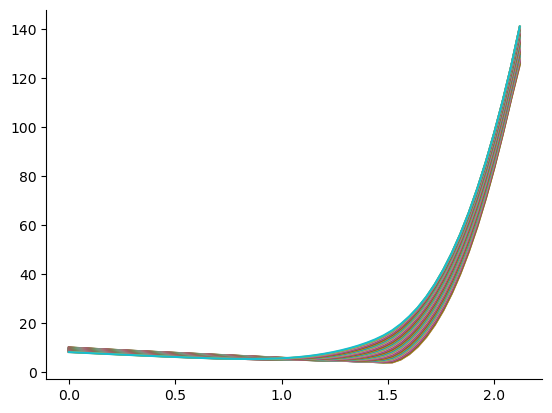

In [57]:
plt.plot(y1_grid_cap, E)
plt.show()

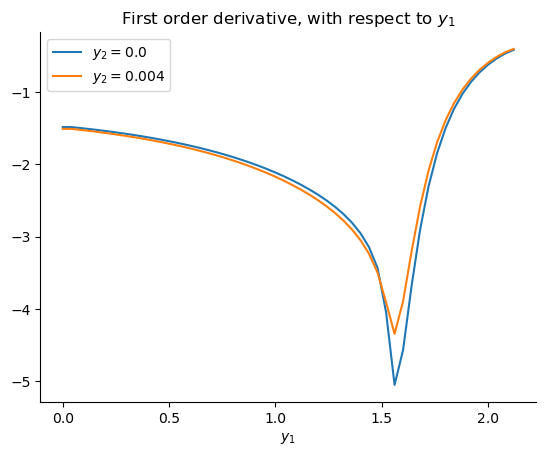

In [46]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, dVdy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, dVdy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

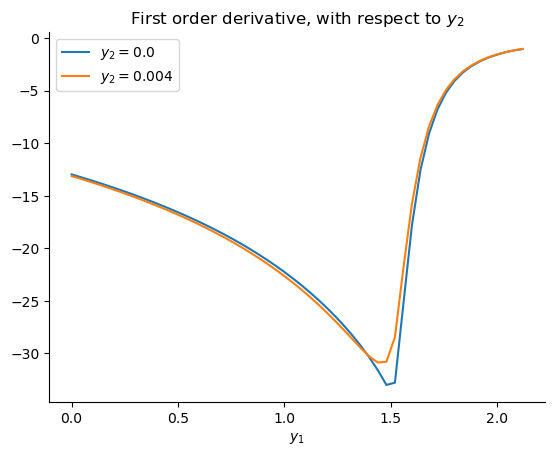

In [47]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, dVdy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, dVdy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

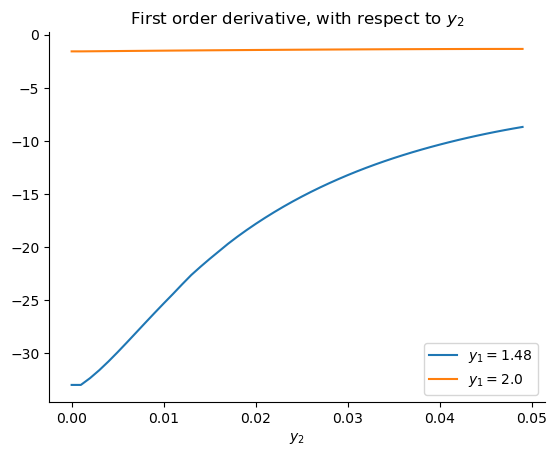

In [48]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, dVdy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, dVdy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

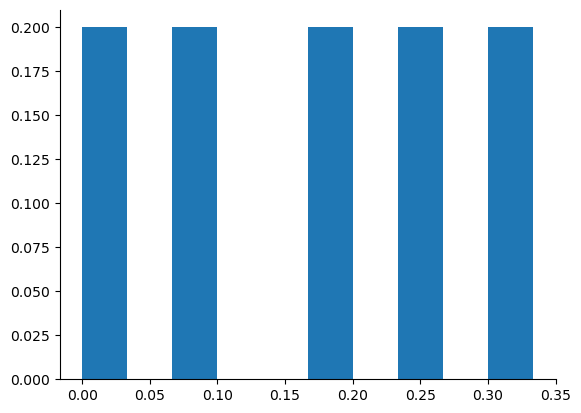

In [49]:
g_i = g_m[:, -1, 2]
plt.hist(gamma_3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

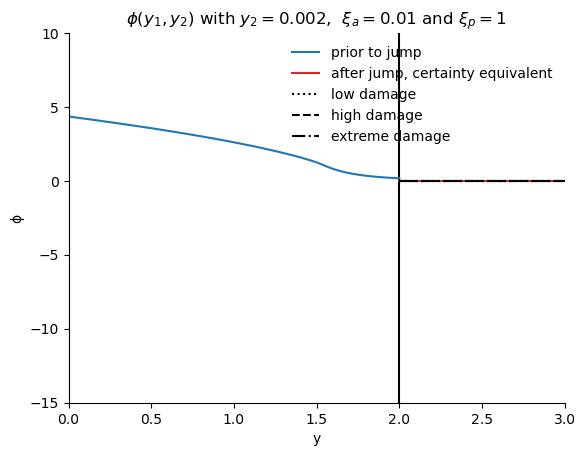

In [50]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

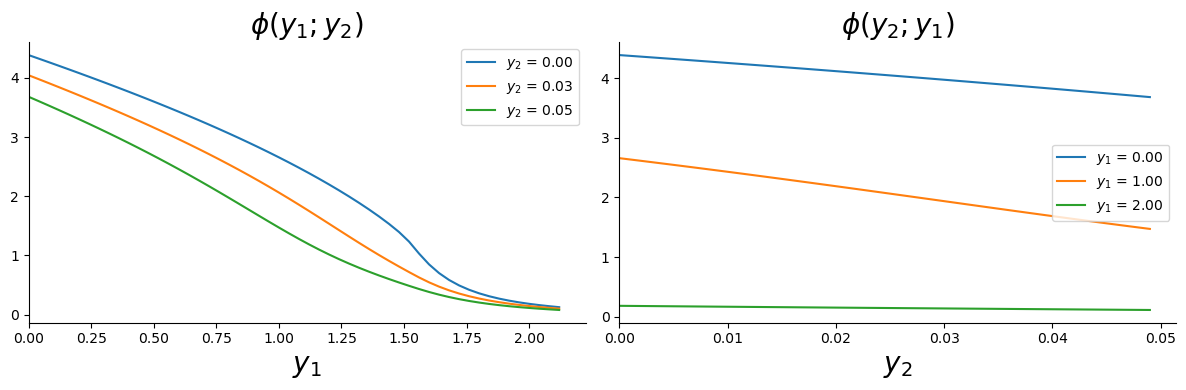

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], V[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], V[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], V[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], V[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], V[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], V[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [52]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, E, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    E_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, E, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = theta*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        E_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        E_t[t] = E_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - lambda0*y2 + lambda0*theta*E_point)*dt
    return Y1t, Y2t, E_t

In [53]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [54]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  E,
                                                  lambda0,
                                                  np.mean(theta_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(theta_list),
                                                  T=93
                                                 )

In [55]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

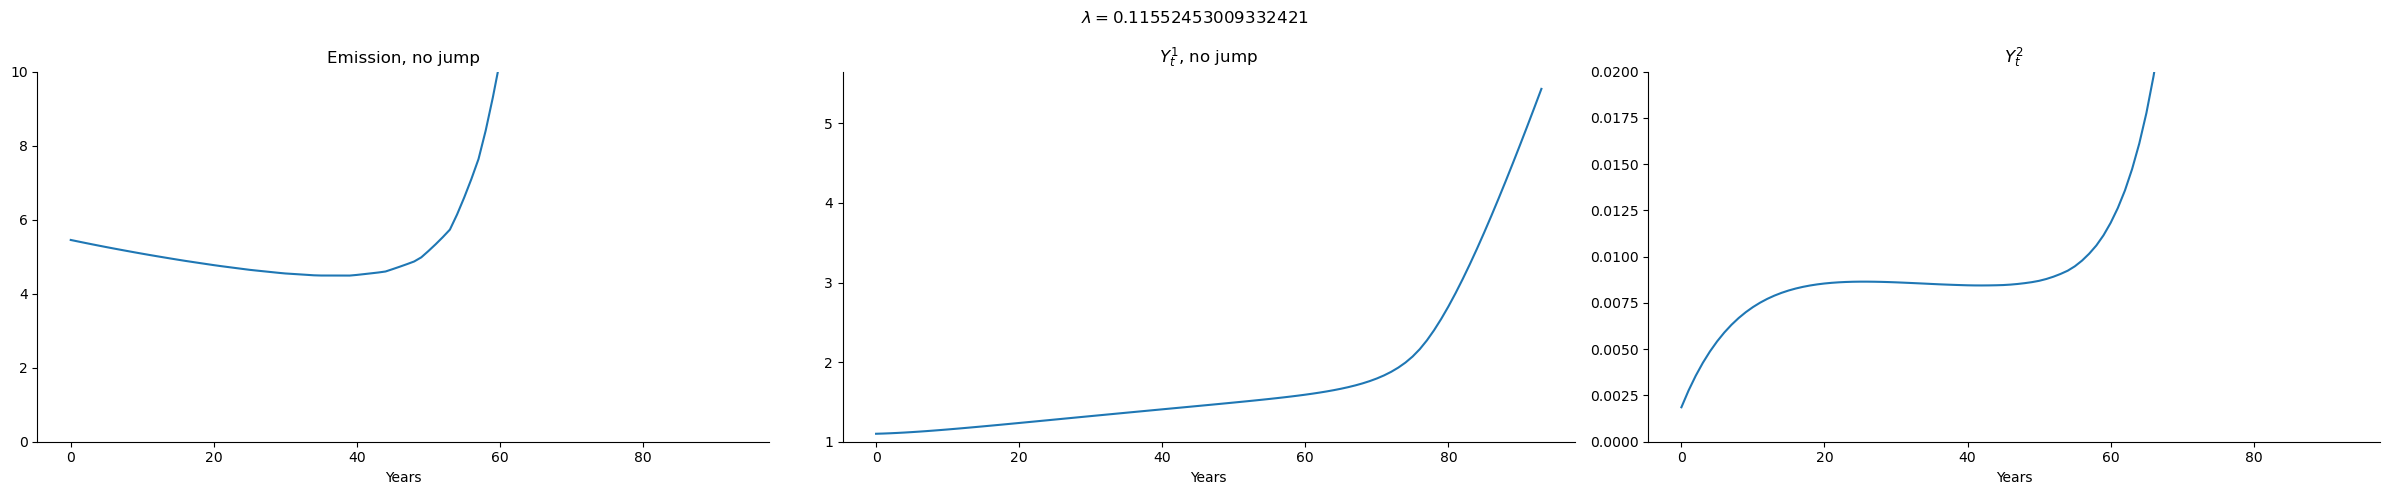

In [56]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {lambda0}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()